# Feature Extraction

In [1]:
# IMPORTS AND NOTEBOOK SETUP
from SimpleCV import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

disp = Display(displaytype='notebook')

## Helper Methods

In [2]:
# HELPER METHODS

# Constant single digit image size
SIZE = 32

# Return an array of individual images and their digit from the image object
def get_individual_images(imgObj):
    return [
        (int(imgObj[0][0]), crop(imgObj[1], 0), crop(imgObj[2], 0)),
        (int(imgObj[0][1]), crop(imgObj[1], 1), crop(imgObj[2], 1)),
        (int(imgObj[0][2]), crop(imgObj[1], 2), crop(imgObj[2], 2)),
        (int(imgObj[0][3]), crop(imgObj[1], 3), crop(imgObj[2], 3))
    ]

# Crop and return a part of the source image
def crop(img, part):
    return img.crop(SIZE * part, 0, SIZE, SIZE)

# Create a list of all images and their file names (labels) in a certain path
def get_images_in_path(path):
    img_list = []
    for name in os.listdir(path):
        if name.endswith('.png'):
            img = Image(os.path.join(path, name))
            label = name[:-4]
            img_list.append((label, img))
    return img_list

## Image Preprocessing

We get all the images from the directory and preprocess them by binarizing, dilating and eroding them in that order.

We also save a non dilated and eroded, but just binarized version for a different purpose explained later.

In [3]:
# IMAGE PRE-PROCESSING
raw = get_images_in_path('../dataset-images/')
images = []
for img in raw:
    _bin = img[1].binarize()
    images.append((img[0], _bin.dilate().erode(), _bin))

Here we tried out different amounts and orders of erosion and dilation. We wanted a clear result, but also a result that does not loose too much detail.

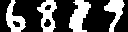

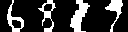

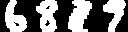

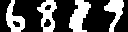

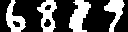

In [4]:
# EXAMPLE IMAGES
images[0][1].save(disp)

img = images[0][1]
img.erode().save(disp)
img.dilate().save(disp)
img.erode().dilate().save(disp)
img.dilate().erode().save(disp)

## Splitting Digits

We split the digits into individual image objects.

In [5]:
# EXTRACTING INDIVIDUAL DIGITS
digits = []
for img in images:
    digits.extend(get_individual_images(img))

We plot a set of images to check how the individual prepocessed images and labels look.

/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


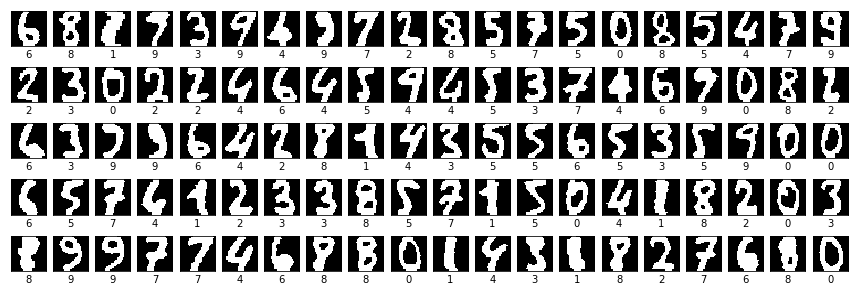

In [6]:
# PLOTTING IMAGES AND THEIR LABELS
PLOT_SIZE = 100
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(digits[i][0])
    plt.imshow(digits[i][1].getNumpy(), cmap=plt.cm.binary)

# Save sample to an image
# plt.savefig('digits_sample', dpi=200, bbox_inches='tight')

## Create Pandas DataFrame with Labels and Image Objects

We also plot the frequency of the digits in the dataset.

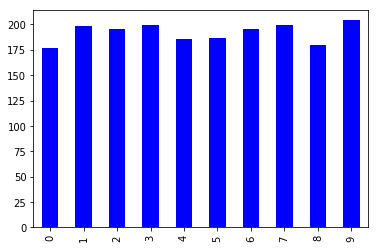

In [7]:
# CREATE DATAFRAME FROM DIGITS
columns = ['digit', 'image', 'image_raw']
data = pd.DataFrame(digits, columns=columns)
data_sorted = pd.DataFrame(sorted(digits), columns=columns)

# PLOT INTERESTING FEATURES
digit_counts = data.digit.value_counts()
digit_counts.sort_index(inplace=True)
digit_counts.plot(kind='bar')

## Low-Res Pixel Count Matrix

We want to create a feature that is based on the pixel count in cells of the image. We used a 4x4 grid (8x8 cells) before but lost too much detail. We use an 8x8 (4x4 cells) grid now.

This cell defines the function ans tests and plots the feature.

Low-Res Pixel Count Matrix based on binarized image


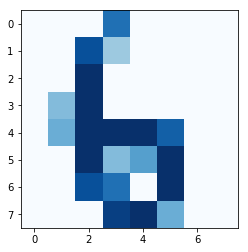


Low-Res Pixel Count Matrix based on binarized, dilated and eroded image


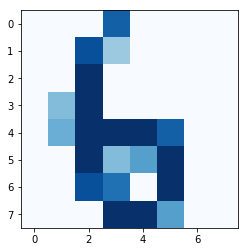

In [8]:
# WEIGHTED MATRIX CREATION
def get_weighted_matrix(img):
    COUNT = 8 # GRID SIZE
    T = 5 # THRESHOLD
    CROP = SIZE / COUNT
    m = np.zeros((COUNT, COUNT))
    for y in range(COUNT):
        for x in range(COUNT):
            part = img.crop(x * CROP, y * CROP, CROP, CROP)
            sum = (part.getNumpy()[:,:,0] / 255).sum()
            m[x][y] = sum if sum > T else 0
    return m.T


img_raw = data.image_raw[0]
img = data.image[0]

m_raw = get_weighted_matrix(img_raw)
print 'Low-Res Pixel Count Matrix based on binarized image'
plt.imshow(m_raw, cmap='Blues', interpolation='nearest')
plt.show()

print

m = get_weighted_matrix(img)
print 'Low-Res Pixel Count Matrix based on binarized, dilated and eroded image'
plt.imshow(m, cmap='Blues', interpolation='nearest')
plt.show()

### Lines, Corners & Circles

We also tried to experiment with findLines, findCorners and findCircle but not a single image contains a line and the amount of corners in the images are not distinctive. Fortunately, circles did seem to be promosing.

[SimpleCV.Features.Detection.Circle at (145,135), SimpleCV.Features.Detection.Circle at (125,99), SimpleCV.Features.Detection.Circle at (129,157)]


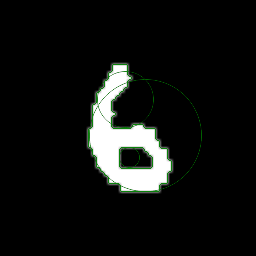

In [107]:
img = data_sorted.image[1300]
img = img.embiggen(2).scale(4)

circles = img.findCircle(thresh=40, distance=20)
print circles
if circles:
    circles.draw()

blobs = img.findBlobs()
if len(blobs) > 0:
    blobs.draw()

img.save(disp)
img.show()

test_dict = {
    'contours': [],
    'corners': [],
    'circles': [],
    'label': []
}

for row in data.iterrows():
    # HACK TO FIND BLOBS
    row[1][1].show()
    # Find blobs in the preprocessed image
    blobs = row[1][1].findBlobs()
    if blobs:
        test_dict['contours'].append(len(blobs[0].contour()))
        test_dict['corners'].append(len(row[1][1].findCorners()))
        
        circles_set = row[1][1].embiggen(2).scale(4).findCircle(thresh=40, distance=20)
        circles = 0
        if circles_set:
            circles = len(circles_set)
        test_dict['circles'].append(circles)
        
        test_dict['label'].append(row[1][0])

# Create dataframe
test_df = pd.DataFrame(test_dict, columns=['contours', 'corners', 'circles', 'label'])

In [108]:
test_df.groupby(test_df.label).mean()

,contours,corners,circles
label,,,
0,34.977401,32.683616,2.841808
1,36.313131,20.575758,0.065657
2,47.071795,25.461538,0.933333
3,52.195980,25.613065,2.175879
4,54.349462,27.688172,0.844086
5,48.401070,25.021390,1.727273
6,42.497436,26.646154,1.564103
7,48.783920,24.663317,0.552764
8,40.138889,27.733333,2.194444


## Extracting Computer Vision Features and Saving to CSV

### Computer Vision based

- Area
  - Number of pixels in the blob.
- Contours
  - Number of contours in the blob.
- Corners
  - Number of corners in the image.
- Radius
  - ?
- Circle Distance
  - ?
- Rectangle Distance
  - ?
- Hull radius
  - ?
- Aspect Ratio
  - Aspect ratio of the width and height of the blob.
- Centroid X
  - The x-coordinate of the centroid.
- Centroid Y
  - The y-coordinate of the centroid.
- Angle
  - ?
- Corners
  - Number of corners found in the image.
- Circles
  - Number of circles found in the image.

### Self Computed Features

- Low-Res Pixel Count Matrix
  - The sum of pixels in a 4x4 cell of the image.
- Number of Holes
  - The number of holes found in the shape.


### Non-features

- Label
  - The correct digit.

First we create a dictionary to save all the features in.

In [109]:
# CREATING DICTIONARY TO SAVE ALL FEATURES IN

# Columns detected using computer vision
features_dict = {
    "area": [],
    "contours": [],
    "radius": [],
    "circle_dist": [],
    "rect_dist": [],
    "hull_radius": [],
    "aspect_ratio": [],
    "centroid_x": [],
    "centroid_y": [],
    "angle": [],
    "corners": [],
    "circles": [],
    "num_holes": [],
    "label": []
}

# Reorder columns
column_order = [
    "area",
    "contours",
    "radius",
    "circle_dist",
    "rect_dist",
    "hull_radius",
    "aspect_ratio",
    "centroid_x",
    "centroid_y",
    "corners",
    "circles",
    "angle"
]

# Adding column names for the low-res pixel count matrix
COUNT = 8
for x in range(COUNT):
    for y in range(COUNT):
        name = '_'.join(['weight', str(x), str(y)])
        column_order.append(name)
        features_dict[name] = []

column_order.append("num_holes")
column_order.append("label")

We then find and calculate all the features we want.

In [110]:
# Iterate through rows of the DataFrame
for row in data.iterrows():
    # HACK TO FIND BLOBS
    row[1][1].show()
    # Find blobs in the preprocessed image
    blobs = row[1][1].findBlobs()
    if blobs:
        blob = blobs[0]
        features_dict['area'].append(blob.area())
        features_dict['contours'].append(len(blob.contour()))
        features_dict['circle_dist'].append(blob.circleDistance())
        features_dict['rect_dist'].append(blob.rectangleDistance())
        features_dict['radius'].append(blob.radius())
        features_dict['hull_radius'].append(blob.hullRadius())
        features_dict['aspect_ratio'].append(blob.aspectRatio())
        features_dict['centroid_x'].append(blob.centroid()[0])
        features_dict['centroid_y'].append(blob.centroid()[1])
        features_dict['angle'].append(blob.angle())
        features_dict['corners'].append(len(row[1][1].findCorners()))
        
        # Finding the number of circles in an image
        circles_set = row[1][1].embiggen(2).scale(4).findCircle(thresh=40, distance=20)
        circles = 0
        if circles_set:
            circles = len(circles_set)
        features_dict['circles'].append(circles)

        # Calculate pixel count matrix in the preprocessed image
        m = get_weighted_matrix(row[1][1])
        COUNT = 8
        for x in range(COUNT):
            for y in range(COUNT):
                features_dict['_'.join(['weight', str(x), str(y)])].append(m[x, y])

        # Finding the number of holes in the 'just binarized' image
        num_holes = len(row[1][2].embiggen(2).invert().findBlobs()[:-1])
        features_dict['num_holes'].append(num_holes)

        # Attach the correct label
        features_dict['label'].append(row[1][0])

# Create dataframe
data_frame = pd.DataFrame(features_dict, columns=column_order)

We reorder the columns of the DataFrame and save the file to CSV

In [115]:
# Save to CSV file
data_frame.to_csv('../dataset-numpy/dataset-v7.csv', sep=',', encoding='utf-8', index=False)

### Peeking into the Created Dataset

In [113]:
data_frame.groupby(data_frame.label).mean()

,area,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,corners,...,weight_6_7,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes
label,,,,,,,,,,,,,,,,,,,,,
0,436.200565,34.977401,12.168335,0.672156,0.101296,12.983805,0.691432,15.598381,15.828897,32.683616,...,0.000000,0,0.000000,4.090395,15.033898,14.519774,5.491525,0.050847,0.000000,0.932203
1,283.767677,36.313131,10.411477,0.962025,0.129142,13.647021,0.968201,15.967314,15.411210,20.575758,...,0.111111,0,0.000000,2.050505,9.398990,13.626263,9.459596,2.035354,0.666667,0.000000
2,249.153846,47.071795,10.030531,0.694135,0.128543,14.820344,0.671576,15.173946,16.647531,25.461538,...,0.051282,0,0.282051,11.169231,14.933333,14.553846,13.517949,9.189744,1.117949,0.005128
3,247.271357,52.195980,10.247545,0.787687,0.052183,14.257641,0.673131,16.822530,15.112528,25.613065,...,0.000000,0,0.175879,10.834171,15.703518,14.185930,7.497487,0.844221,0.000000,0.000000
4,264.500000,54.349462,9.718960,0.421550,0.179503,12.896112,1.342215,15.672327,16.063245,27.688172,...,0.000000,0,0.000000,0.747312,6.629032,11.930108,2.220430,0.086022,0.043011,0.026882
5,242.818182,48.401070,10.023547,0.840482,0.079014,14.014906,1.015359,14.928513,14.208563,25.021390,...,0.000000,0,0.074866,9.475936,15.540107,11.561497,2.925134,0.262032,0.000000,0.005348
6,298.943590,42.497436,10.977417,0.648495,0.166494,13.179918,0.600394,15.586234,18.863357,26.646154,...,0.317949,0,0.000000,0.948718,11.758974,15.830769,14.528205,5.625641,0.143590,0.758974
7,250.062814,48.783920,9.765547,0.699069,0.157496,13.715756,0.924716,16.766939,13.385786,24.663317,...,0.000000,0,0.241206,8.442211,11.512563,0.989950,0.070352,0.000000,0.000000,0.000000
8,360.491667,40.138889,10.758700,0.820820,0.075461,13.820539,0.840006,15.182823,15.285047,27.733333,...,0.000000,0,0.000000,5.777778,14.766667,13.833333,7.033333,0.483333,0.000000,1.444444


In [111]:
data_frame.head()

,area,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,corners,...,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes,label
0,288.0,36,11.535813,0.665268,0.164439,12.633042,0.582609,14.199074,19.315972,24,...,0,0,0,16,16,9,0,0,1,6
1,348.5,39,10.709997,0.700282,0.103448,13.732948,0.655172,15.272119,14.962219,26,...,0,0,0,16,16,6,0,0,2,8
2,345.0,48,11.186796,0.594529,0.005792,14.444992,1.683333,14.761353,15.188406,24,...,0,0,13,16,12,6,0,0,0,1
3,243.0,42,10.376487,0.674817,0.262069,12.915362,0.689655,18.580247,10.787380,24,...,0,0,0,12,8,0,0,0,0,9
4,213.0,48,9.848953,0.697099,0.083561,13.695002,0.564815,16.989828,15.674491,26,...,0,0,10,16,16,16,0,0,0,3


In [112]:
data_frame.describe()

,area,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,corners,...,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes,label
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,291.653385,44.952083,10.493405,0.725179,0.119105,13.664167,0.852753,15.859298,15.380416,26.293750,...,0,0.079167,5.926042,12.834896,12.289062,7.040625,2.013542,0.205208,0.379688,4.532813
std,67.428881,8.744703,0.889372,0.263723,0.068749,0.814930,0.439098,1.193617,1.869070,4.623068,...,0,0.749489,6.019748,4.961796,5.708873,6.887045,4.605639,1.469358,0.584767,2.868122
min,153.000000,20.000000,8.303587,0.225470,0.000000,11.549360,0.310345,11.835737,10.582800,11.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,244.000000,39.000000,9.822737,0.581376,0.063434,13.067626,0.605262,15.077516,14.116460,23.000000,...,0,0.000000,0.000000,12.000000,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,275.500000,44.000000,10.369215,0.687549,0.116046,13.617666,0.655172,15.797984,15.295089,26.000000,...,0,0.000000,6.000000,16.000000,16.000000,7.000000,0.000000,0.000000,0.000000,5.000000
75%,326.000000,51.000000,11.043633,0.795775,0.173021,14.191667,0.724138,16.571982,16.354908,29.000000,...,0,0.000000,11.250000,16.000000,16.000000,14.000000,0.000000,0.000000,1.000000,7.000000
max,512.000000,88.000000,13.117590,3.119437,0.329466,16.446964,3.171172,20.410788,20.841542,48.000000,...,0,11.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,2.000000,9.000000


### Checking the Quality of the Number of Holes Feature

In [15]:
data_frame.groupby(['label','num_holes']).size()

label  num_holes
0      0             12
       1            165
1      0            198
2      0            194
       1              1
3      0            199
4      0            181
       1              5
5      0            186
       1              1
6      0             47
       1            148
7      0            199
8      0             22
       1             56
       2            102
9      0             55
       1            149
dtype: int64